<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Google_CoLab_GAN_sprites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Loading Libraries*

In [1]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 54kB/s 
     |████████████████████████████████| 3.1MB 33.7MB/s 
     |████████████████████████████████| 501kB 62.4MB/s 


In [0]:
%%capture
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
if os.path.isdir ('input-sprites'):
  print ('Sprite directory already exists.')
else:
  os.makedirs ('input-sprites')

In [0]:
%%capture
!unzip input-sprite.zip -d input-sprites/

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Reshape, Flatten, Dropout, Concatenate, Conv2DTranspose, GlobalMaxPooling2D, MaxPooling1D, GaussianNoise, BatchNormalization, MaxPooling2D, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D, Embedding, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

### *Custom Function*

In [0]:
def load_image (image):
  image = Image.open(image)                     # load image files
  image = image.convert('RGB')                  # convert RGB = 3 channels
  pixels = np.asarray(image)                    # convert to array
  return pixels

In [0]:
def load_sprite (directory):
  sprites = []
  for png in os.listdir (directory):
    if png.endswith('.png'):                    # check that image file is being processed
      pixels = load_image(directory + '/' + png)
      sprites.append (pixels)
  return np.asarray (sprites)

In [0]:
real = load_sprite ('input-sprites')

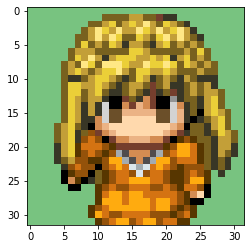

In [10]:
plt.imshow(real[0])
plt.show()

In [0]:
N, H, W, K = real.shape

In [0]:
latent = 128
batch = 32

[*Basing on this model.*](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)

In [0]:
def discriminator_nn (image):
  i = Input (shape=(image))
  
  # convolutions
  x = Conv2D (128, (5,5), padding='same') (i)
  x = LeakyReLU (0.2) (x)

  x = Conv2D(128, (5,5), strides=(2,2), padding='same') (x)
  x = LeakyReLU (0.2) (x)

  x = Conv2D(128, (5,5), strides=(2,2), padding='same') (x)
  x = LeakyReLU (0.2) (x)

  x = Conv2D(128, (5,5), strides=(2,2), padding='same') (x)
  x = LeakyReLU (0.2) (x)

  # flatten
  x = Flatten () (x)
  x = Dropout (0.5) (x)

  # sequentail
  x = Dense (256, activation=LeakyReLU(alpha=0.2))  (x)
  x = BatchNormalization (momentum=0.8) (x)

  x = Dense (128, activation=LeakyReLU(alpha=0.2))  (x)
  x = BatchNormalization (momentum=0.8) (x)

  x = Dense (1, activation='sigmoid') (x)
  model = Model (i, x)

  return model

In [0]:
def generator_nn (latent, sH=4, sW=4, batch=32):
  nodes = batch * sH * sW
  
  i = Input (shape=(latent,))
  x = Dense (nodes) (i)
  x = Reshape ((sH, sW, batch)) (x)

  # reverse convolution
  x = Conv2DTranspose (batch, (4,4), strides=(2,2), padding='same') (x)
  x = LeakyReLU (0.2) (x)

  x = Conv2DTranspose (batch, (4,4), strides=(2,2), padding='same') (x)
  x = LeakyReLU (0.2) (x)

  x = Conv2DTranspose (batch, (4,4), strides=(2,2), padding='same') (x)
  x = LeakyReLU (0.2) (x)

  # output layer should be 32 = 4 * 2 * 2 * 2
  # last node are the 3 channels = RGB

  x =  Conv2D (3, (5,5), activation='tanh', padding='same')(x)
  model = Model (i, x)

  return model

In [0]:
discriminator = discriminator_nn ((H,W,K))

In [0]:
discriminator.compile (
    loss = 'binary_crossentropy',
    optimizer = Adam (0.0002, 0.5),
    metrics=['accuracy']
)

In [0]:
generator = generator_nn (latent)
z = Input (shape=(latent,))                       # noise sample
image = generator (z)                             # pass z into the generator

discriminator.trainable = False                   # somehow this is not inherited later
fake_pred = discriminator (image)

combined = Model (z, fake_pred)

In [0]:
combined.compile (
    loss = 'binary_crossentropy',
    optimizer = Adam (0.0002, 0.5)
)

In [0]:
batch = 32
epochs = 12000
sample_period = 2000

In [22]:
real.shape

(742, 32, 32, 3)

In [0]:
ones = np.ones (batch) # creating batch labels ahead of time
zeros = np.zeros (batch)

In [0]:
d_losses = []
g_losses = []

In [0]:
def sample_images (epoch):
  rows, cols = 5, 5
  noise = np.random.randn (rows*cols, latent)
  images = generator.predict (noise) # have the generator make a sample image from the noise

  # images = 0.5 * images + 0.5 # rescaling to be between 0 and 1

  fig, axs = plt.subplots (rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i, j].imshow(images[idx].reshape(H,W), cmap='Reds')
      axs[i, j].axis('off')
      idx += 1 # this is just graphing 1 by 1
  fig.savefig ('gan_images/%d.png' % epoch)
  plt.close()

In [23]:
noise = np.random.randn (rows*cols, latent)

742

In [0]:
X = real
y = np.ones (len (real))

In [0]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.85, random_state=23)

In [32]:
for epoch in range (epochs):
  # train discriminator
  idx = np.random.randint (0, X_train.shape[0], batch) # select random images from index 0 to size of X_train, in a batch size group
  real_images = X_train [idx]

  noise = np.random.randn (batch, latent)
  fake_images = generator.predict(noise)

  # generator.trainable = False
  # discriminator.trainable = True

  # print (discriminator.trainable)

  d_loss_real, d_acc_real = discriminator.train_on_batch (real_images, ones) # (X, y)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch (fake_images, zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake) # mean of losses and accuracies
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  if epoch % sample_period == 0:
    print ('Trainable (D) : %a ' %discriminator.trainable)

  # train generator
  noise = np.random.randn (batch, latent)
  
  # generator.trainable = True
  # discriminator.trainable = False

  

  g_loss = combined.train_on_batch (noise, ones) # flipped from discriminator

  d_losses.append (d_loss)
  g_losses.append (g_loss)

  if epoch % sample_period == 0:
    print ('Trainable (G) : %a ' %discriminator.trainable)
    print ('Discriminator Loss : %a' %d_loss)
    print ('Generator Loss : %a' %g_loss) 
    print ('Epoch : %a' %epoch )
    print ('***')

  # if epoch % 1000 == 0:
    # sample_images (epoch=epoch)

Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.349805623292923
Generator Loss : 0.6911738
Epoch : 0
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 7.712474822998047
Generator Loss : 14.340452
Epoch : 2000
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 7.712474346160889
Generator Loss : 15.231741
Epoch : 4000
***


KeyboardInterrupt: ignored

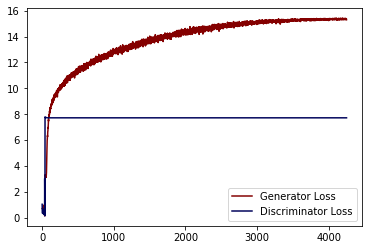

In [33]:
plt.plot (g_losses, label='Generator Loss', color='#840000')
plt.plot (d_losses, label='Discriminator Loss', color='#00035b')
plt.legend ()

In [36]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          16416     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        16416     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 32)        0   

In [37]:
discriminator.summary ()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0     

In [0]:
noise = np.random.randn (1, latent)

In [45]:
noise

array([[ 0.29407797,  0.75984749,  0.71651068, -0.04566593, -0.18099474,
         0.55506907, -1.5566549 , -0.61754332,  2.07656436, -0.05625076,
         1.17860616, -0.32339557,  0.20735795,  0.10843698,  0.96269046,
        -0.749626  ,  1.42189673,  0.90976916, -0.15653447,  0.58312298,
        -1.76990758, -1.14642524,  0.37624906,  0.07193522, -1.12485728,
         0.27137594,  0.17548437, -0.87987921,  1.46143047, -0.56335295,
        -0.99907495, -0.85113364,  1.13630761,  0.31613659, -0.9078717 ,
         0.46218773, -0.67648538,  2.57961138, -0.92064776,  0.74405915,
         0.49879047, -1.28674324, -1.35093041, -0.53897615,  1.32625954,
         0.84899609, -0.15259148,  0.07084311, -0.97709443,  0.07134667,
        -1.03065872, -1.22357319,  2.23987739, -0.97065719,  0.23181038,
         0.07537616, -0.43285878,  0.40037377, -1.73323504,  0.58521776,
         0.1478622 , -0.76776849, -0.16973747,  2.07071273,  0.08811775,
         1.01075025,  0.31071905,  1.58805807, -0.6